## Where do lightning storms initiate?

**Why do we care?**
If we know where they are likely to initiate and how they move under certain conditions, then we can predict where lightning and hence flooding and other damages will occur. 

**What do we expect?**
Any change in terrain should be a big deal and also possibly cities.

**How have other people done it?**
"We computed the probability that a grid of resolution 0.02° by 0.02° was the initiation location by taking the first 100 CG strikes for each of the 10 days and computing the frequency by grid." (Ntelekos et al, 2007)

**How are we going to figure it out?**
To tackle this question within a particular region, we could use an event-based method, or a climatological method. Climatological seems more robust because there is no introduced bias from how we select events. We could set a threshold (or perhaps a couple thresholds) and see where the first instance of exceedence occurs given a certain storm-free period prior to that exceedence and a buffer around the bounding box that must not contain any storms. We could do these calculations on smoothed or unsmoothed data. To start with we can try doing this on unsmoothed data with a threshold of one strike. Should we also put some requirement to make sure that a storm occurs after the intitation?

In [1]:
%matplotlib inline
import pandas as pd
from pointprocess import *
from lightning_setup import *
from cartopy.io.img_tiles import StamenTerrain

In [55]:
c = Region(city=cities['cedar'])
c.define_grid()

# initialize some variable names
df=None
df_10=None
df_20=None
df_50=None

In [64]:
# open dataset for the months that you are interested in
ds = c.get_ds(m=7, func=None)

# get the time difference between each strike
t_diff = pd.TimedeltaIndex(np.diff(ds.time))

# bool of whether difference is greater than 1 hour and less than 20 days (aka not a whole year)
cond=(t_diff>pd.Timedelta(hours=1)) & (t_diff<pd.Timedelta(days=20))

# make a dataframe of all the records when this is the case and reset the index
df0 = ds.record[1:][cond].to_dataframe().drop('record', axis=1).reset_index()

# count the strikes in the next hour
ml = [((ds.time>t.asm8) & (ds.time<(t+ pd.Timedelta(hours=1)).asm8)).sum().values for t in df0.time]

ds.close()

In [70]:
df = pd.concat([df, df0])

df_10 = pd.concat([df_10, df0[np.array(ml)>10]])
df_20 = pd.concat([df_20, df0[np.array(ml)>20]])
df_50 = pd.concat([df_50, df0[np.array(ml)>50]])

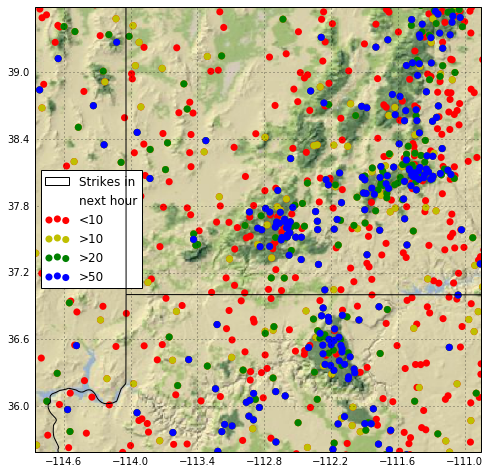

In [72]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
background(ax)
kwargs=dict(x='lon', y='lat', ax=ax, s=50, edgecolor='None')
df.plot.scatter(c='r', **kwargs)
df_10.plot.scatter(c='y', **kwargs)
df_20.plot.scatter(c='g', **kwargs)
df_50.plot.scatter(c='b', **kwargs)
ax.set_extent([c.gridx.min()+1, c.gridx.max()-1, c.gridy.min()+1, c.gridy.max()-1])
ax.add_image(StamenTerrain(), 7)
plt.legend(['Strikes in', 'next hour',
            '<10', '>10','>20', '>50'], loc='center left');
plt.savefig('./output/cedar/JA Initiation Locations.png')